## 大綱
1. 套件說明
2. CKIP 介紹
    + 2.1 安裝CKIP
    + 2.2 利用CKIP進行自然語言處理
3. CKIP 標註
    + 3.1 將抓取結果用CKIP進行處理
    + 3.2 探索分析 - NER
    + 3.3 探索分析 - POS
4. 利用SnowNLP進行情緒分析

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- CKIP: 全名為Chinese Knowledge and Information Processing，中研院開發的中文自然語言處理工具。
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。
- SnowNLP: SnowNLP是一個可以方便的處理中文文本內容的python類庫，是受到了TextBlob的啟發而寫的。SnowNLP主要功能包括斷詞、詞性標註、情緒分析、漢字轉拼音、繁體轉簡體、關鍵詞提取以及文本摘要等等。

In [1]:
# 安裝會使用到的套件
# 安裝ckiptagger前要先安裝tensorflow，有套件相依的問題
# %pip install ckiptagger[tf,gdown] wordcloud SnowNLP

In [2]:
# 確認當前工作目錄
# %pwd

In [3]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io
from wordcloud import WordCloud, ImageColorGenerator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

如果有重新裝package，記得需要restart kernel 才會使用更新後的套件

## 2. CKIP 介紹
- 是中研院詞庫小組開發的中文自然語言處理套件，其斷詞效果比起`jieba`效果更好，並且提供性命名實體辨識、詞性標註、句法分析
- github: https://github.com/ckiplab/ckiptagger

### 2.1 CKIP安裝

In [4]:
# data_utils.download_data_gdown("./") # gdrive-ckip # 下載ckip model

### 2.2 利用CKIP進行自然語言處理
透過ckip這個套件可以對文集進行斷詞、命名實體辨識、詞性標記等處理
+ CKIP 標註任務
    + 斷詞（ws）
        + 可以設定自己的辭典
            + `recommend_dictionary` 推薦字典
            + `coerce_dictionary` 強制字典
    + 實體辨識（ner）
    + 詞性標註（pos）
+ NER與POS名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [5]:
# 將三份工具的模型路徑指向我們剛才下載的 data.zip
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

d:\anaconda3\lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
d:\anaconda3\lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
d:\anaconda3\lib\site-packages\ckiptagger\model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)


In [6]:
# # 自定義辭典
# word_to_weight = {
#     "魔法覺醒": 1,
#     "睽違已久": 2,
# }
# dictionary1 = construct_dictionary(word_to_weight)
# print(dictionary1)

In [7]:
# sentence_list = [
#     "哈利波特魔法覺醒是一個中國網易代理的粉絲睽違已久的手遊app",
#      "很多人滿心期待這款英國出品的遊戲，卻又害怕受傷害"
# ]

# word_sentence_list = ws(sentence_list, coerce_dictionary = dictionary1)  # 斷詞
# pos_sentence_list = pos(word_sentence_list)
# entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

# def print_word_pos_sentence(word_sentence, pos_sentence):
#     assert len(word_sentence) == len(pos_sentence)
#     for word, pos in zip(word_sentence, pos_sentence):
#         print(f"{word}({pos})", end="\u3000")
#     print()
#     return
    
# for i, sentence in enumerate(sentence_list):
#     print()
#     print(f"sentence {i}: {sentence}")
#     print("\nPOS: ")
#     print_word_pos_sentence(word_sentence_list[i],  pos_sentence_list[i])
#     print("\nNER: ")
#     for entity in sorted(entity_sentence_list[i]):
#         print(entity)

## 3. CKIP 標註

### 3.1 將抓取結果用CKIP進行處理

- 資料來源: 工作流程蒐集PTT 八卦版 Food 2023-03-08 ~ 2023-03-13 所有文章
- 03/08~03/13正是本次經典賽A組中華隊的賽程

|日期|時間|隊伍(_勝隊_ 敗隊)|比數|
|---|---|---|---|
|3/08(三)|19：00|_**巴拿馬**_ VS 中華隊|12：5|
|3/10(五)|12：00|義大利 VS _**中華隊**_|7：11|
|3/11(六)|19：00|荷蘭 VS _**中華隊**_|5：9|
|3/12(日)|12：00|中華隊 VS _**古巴**_|1：7|

* Tarflow搜尋關鍵字: WBC、世界棒球經典賽、中華隊、啦啦隊、、經典女孩、Major League Baseball、MLB、**中華隊教練名單**、**中華隊球員名單**、**啦啦隊名單**、**基本棒球術語**、**球員教練綽號**

    ```python
    CT_coach = {'林岳平','彭政閔','王建民','高志綱','曾豪駒','許銘傑','陳江和','張建銘','劉品辰'}#中華隊教練名單

    CT_player = {'宋家豪','鄧愷威','王維中','陳冠偉','陳禹勳','陳冠宇','黃子鵬','胡智為','李振昌','呂彥青','吳哲源','江少慶',
                '曾峻岳','陳仕朋','吉力吉撈','鞏冠','林岱安','高宇杰','吳念庭','張育成','林子偉','鄭宗哲','江坤宇','王威晨',
                '范國宸','林立','王柏融','成晉','陳晨威','陳傑憲','郭天信'
                }#中華隊球員名單

    CT_gril = {'峮峮','貴貴','短今','Paggy','妮可','林襄','孟潔','Yuri','籃籃','心璇',
                '小映','賴可','琪琪','艾璐','Yuki','瑟七','Faye','丹丹','秀秀子','奶昔','慈妹'
                }#啦啦隊名單

    baseball_rule = {'安打','全壘打','雙殺','出局','滿貫砲','陽春砲','接殺','漏接','四壞','保送','三振','短打','盜壘'}#基本棒球術語

    nick_name ={'大餅','投手','大王','小玉','二兵','國防部長','三軍統帥','逃兵'}#球員教練綽號

    ```

    * 排除關鍵字: 籃球,足球,烏克蘭,俄羅斯,戰爭,核彈,核武,打仗,僵局,統治,中國,八卦,仇恨,二膽,金門,Re:[新聞],黑道


In [8]:
## 讀取文章且去掉na值
df = pd.read_csv('./raw_data/zh/WBC.csv').dropna(how='any')
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Gossiping/M.1678205469....,[問卦]林襄有什麼代表作啊??,2023-03-08 00:11:07,OPPAISuki,Gossiping,都說林襄很紅 現在棒球新聞都是林襄 沒人關心球員\n\n請問一下 林襄 的代表作是什麼啊??...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Julian9x9x9""...",36.224.93.130,2023-03-08 01:45:33,ptt
1,2,https://www.ptt.cc/bbs/Gossiping/M.1678208423....,Re:[問卦]棒球是過氣了嗎,2023-03-08 01:00:21,richshen,Gossiping,不是啊\n\n你要不要先看一下售票狀況啊\n\n最貴的一張3200 內野最便宜的2000 連...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""andytaso"", ""...",61.57.148.9,2023-03-08 01:45:47,ptt
2,3,https://www.ptt.cc/bbs/Gossiping/M.1678208912....,[新聞]「當你害羞人生會錯過許多機會」李維拉,2023-03-08 01:08:30,micheal59,Gossiping,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:自由時報\n\n2.記者署名: 記者羅...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""StylishTrade...",42.77.198.43,2023-03-08 01:45:54,ptt


定義文字清理的相關function

In [9]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#    paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), str(article).split("\n")))#會遇到float所以把article強制轉成str
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

(2) CKIP 處理相關function

In [10]:
# 自定義辭典
with open('dict/user_dict.txt') as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

[(2, {'鞏冠': 500.0, '林立': 500.0, '成晉': 500.0, '峮峮': 500.0, '貴貴': 500.0, '短今': 500.0, '妮可': 500.0, '林襄': 500.0, '孟潔': 500.0, '籃籃': 500.0, '心璇': 500.0, '小映': 500.0, '賴可': 500.0, '琪琪': 500.0, '艾璐': 500.0, '瑟七': 500.0, '丹丹': 500.0, '奶昔': 500.0, '慈妹': 500.0, '安打': 500.0, '雙殺': 500.0, '出局': 500.0, '大餅': 500.0, '投手': 500.0, '大王': 500.0, '小玉': 500.0, '二兵': 500.0, '逃兵': 500.0, '接殺': 500.0, '漏接': 500.0, '四壞': 500.0, '保送': 500.0, '三振': 500.0, '短打': 500.0, '盜壘': 500.0}), (3, {'WBC': 500.0, '中華隊': 500.0, '林岳平': 500.0, '高志綱': 500.0, '曾豪駒': 500.0, '彭政閔': 500.0, '許銘傑': 500.0, '王建民': 500.0, '陳江和': 500.0, '張建銘': 500.0, '劉品辰': 500.0, '宋家豪': 500.0, '鄧愷威': 500.0, '王維中': 500.0, '陳冠偉': 500.0, '陳禹勳': 500.0, '陳冠宇': 500.0, '黃子鵬': 500.0, '胡智為': 500.0, '李振昌': 500.0, '呂彥青': 500.0, '吳哲源': 500.0, '江少慶': 500.0, '曾峻岳': 500.0, '陳仕朋': 500.0, '林岱安': 500.0, '高宇杰': 500.0, '吳念庭': 500.0, '張育成': 500.0, '林子偉': 500.0, '鄭宗哲': 500.0, '江坤宇': 500.0, '王威晨': 500.0, '范國宸': 500.0, '王柏融': 500.0, '陳晨威': 500.0, '陳傑憲': 500.0, '郭天信': 500.0, 

In [11]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'],sentence])            
            temp_tokens = get_pos(row['system_id'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [12]:
# 看看tmp和flat_list有什麼差別
tmp = Sentence_Segmentation(df['artContent'][0]) 
flat_list = [item for sublist in tmp for item in sublist]
print(tmp[:5])
print(flat_list[:5])

[['都說林襄很紅現在棒球新聞都是林襄沒人關心球員'], ['請問下林襄的代表作是什麼啊', '我沒什麼印象耶'], ['前輩峮峮至少有炸裂陳子豪那個音樂應援舞還紅到日本去了'], ['甚至有劇情有女優在跳炸裂陳子豪真的文化輸出了'], ['有掛嗎']]
['都說林襄很紅現在棒球新聞都是林襄沒人關心球員', '請問下林襄的代表作是什麼啊', '我沒什麼印象耶', '前輩峮峮至少有炸裂陳子豪那個音樂應援舞還紅到日本去了', '甚至有劇情有女優在跳炸裂陳子豪真的文化輸出了']


In [13]:
# pos_table, entity_table, sentence_table = get_nlp_result(df)

+ 欄位名稱介紹
    + pos_table 欄位:
        + system_id : ptt 貼文id
        + word: 原始斷詞
        + pos : part-of-speech,詞性
    + entity_table 欄位:
        + system_id : ptt 貼文id
        + word: 原始斷詞
        + ner: 命名實體
    + sentence_table 欄位:
        + system_id : ptt 貼文id
        + text: 原始斷句

In [14]:
# pos_table.head() # word pos 列表

In [15]:
# entity_table.head() # word entity 列表

In [16]:
# sentence_table.head()

In [17]:
# # 檢查筆數
# print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 1628篇文
# print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 1620篇有抓到ner

In [18]:
# # 將文章存成csv
# pos_table.to_csv('raw_data/zh/pos_table_buffet.csv', index = False)
# entity_table.to_csv('raw_data/zh/entity_table_buffet.csv', index = False)
# sentence_table.to_csv('raw_data/zh/sentence_table_buffet.csv', index = False)

### 3.2 探索分析 - NER

將剛才分析的資料匯入

In [19]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("raw_data/zh/pos_table_buffet.csv") 
entity_table = pd.read_csv("raw_data/zh/entity_table_buffet.csv") 
sentence_table = pd.read_csv("raw_data/zh/sentence_table_buffet.csv") 

### NER 種類分析
查看標註這個文集後辨識出哪一些實體種類<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [20]:
entity_table['ner'].unique()

array(['PERSON', 'GPE', 'CARDINAL', 'WORK_OF_ART', 'DATE', 'TIME', 'FAC',
       'ORG', 'ORDINAL', 'NORP', 'LOC', 'EVENT', 'LANGUAGE', 'PRODUCT',
       'MONEY', 'PERCENT', 'QUANTITY', 'LAW'], dtype=object)

In [21]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(8)
ner_count

,ner,count
4,GPE,3852
13,PERSON,2942
11,ORG,2455
1,DATE,1252
0,CARDINAL,794
16,TIME,383
2,EVENT,305
9,NORP,290


C:\Users\TSH13\AppData\Local\Temp/ipykernel_4544/3390866936.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


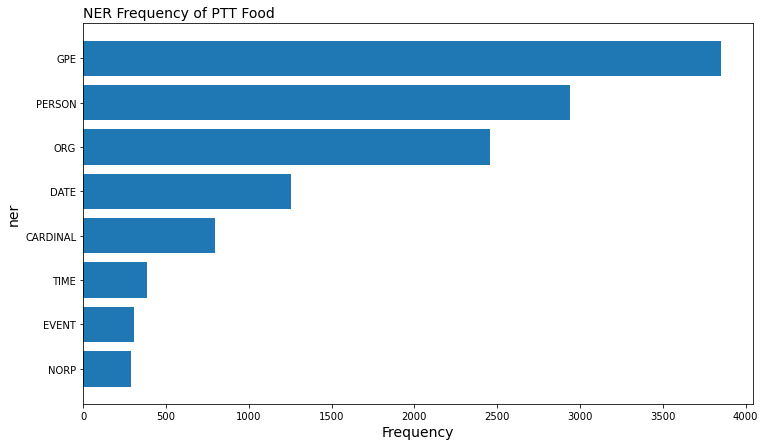

In [22]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Food',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的人名(PERSON)

C:\Users\TSH13\AppData\Local\Temp/ipykernel_4544/3331849998.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


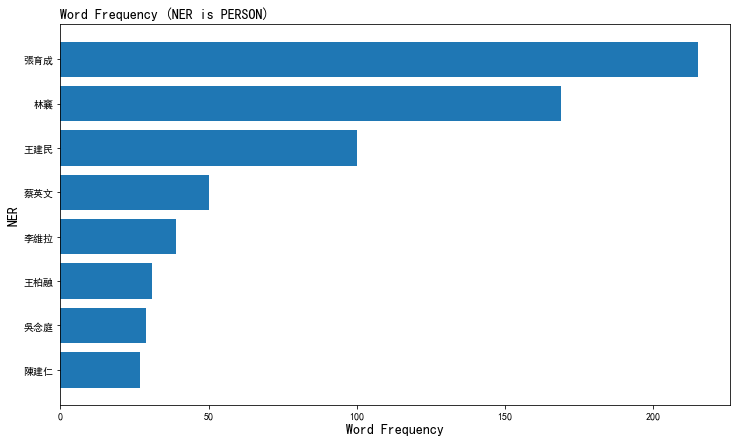

In [23]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 涉及到的組織(ORG)

C:\Users\TSH13\AppData\Local\Temp/ipykernel_4544/4048620738.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


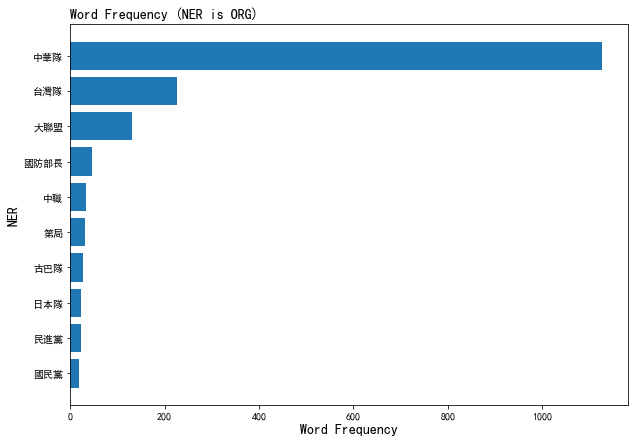

In [24]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 涉及到的民族、宗教、政治團體(NORP)

C:\Users\TSH13\AppData\Local\Temp/ipykernel_4544/3111702445.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


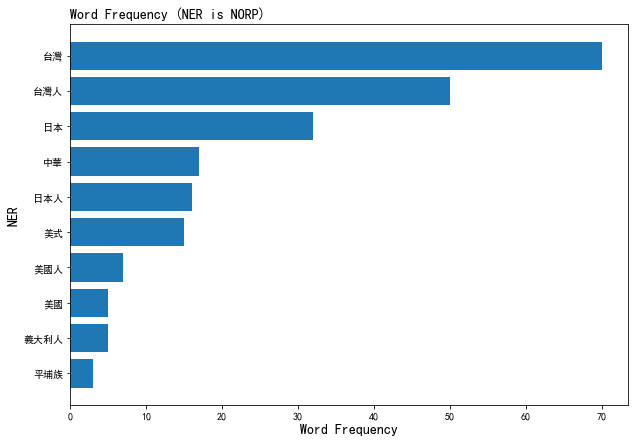

In [25]:
# 篩選ner為名詞的資料
l_noun = ["NORP"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [26]:
keyword_list = ['中華隊']
thailand_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{thailand_selected.shape[0]}篇相關貼文")
thailand_selected.head(3)

中華隊：673篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
1,2,https://www.ptt.cc/bbs/Gossiping/M.1678208423....,Re:[問卦]棒球是過氣了嗎,2023-03-08 01:00:21,richshen,Gossiping,不是啊\n\n你要不要先看一下售票狀況啊\n\n最貴的一張3200 內野最便宜的2000 連...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""andytaso"", ""...",61.57.148.9,2023-03-08 01:45:47,ptt
3,4,https://www.ptt.cc/bbs/Gossiping/M.1678215665....,[問卦]熱血主播將轉播這次WBC,2023-03-08 03:01:03,a12c45a,Gossiping,是D 就在今天！\n眾所矚目的\nWBC\n地區分組賽\n就在今天3/8號即將登場\n我們台...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Dinenger"", ""...",111.242.207.168,2023-03-09 01:33:47,ptt
5,6,https://www.ptt.cc/bbs/Gossiping/M.1678235465....,[新聞]經典賽／林襄高清特寫照曝光網緊盯一部位,2023-03-08 08:31:03,area51gold,Gossiping,備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n東森新聞\n2.記者署名:\n責任...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""zkow"", ""cmtC...",42.75.116.30,2023-03-09 01:34:30,ptt


### 3.3 探索分析 - POS

#### POS 種類分析
查看辨識出哪幾種POS<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [27]:
pos_table['pos'].unique()

array(['D', 'VE', 'Nb', 'Dfa', 'VH', 'Nd', 'Na', 'SHI', 'VJ', 'VK', 'Ng',
       'DE', 'Nep', 'T', 'Nh', 'FW', 'Da', 'V_2', 'VC', 'Nf', 'VCL', 'Nc',
       'Di', 'P', 'VA', 'VD', 'Dk', 'Neu', 'VG', 'VF', 'Neqa',
       'COMMACATEGORY', 'Caa', 'VHC', 'Neqb', 'Cbb', 'Nes', 'Ncd', 'Nv',
       'Cab', 'VB', 'VL', 'A', 'VAC', 'VI', 'I', 'PARENTHESISCATEGORY',
       'Dfb', 'Cba', 'DM', 'PERIODCATEGORY'], dtype=object)

看看除了標點符號，大部分的POS都是哪一類

In [28]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

,pos,count
15,Na,25376
5,D,13514
35,VC,10875
41,VH,7669
17,Nc,6514
29,P,4451
6,DE,3995
16,Nb,3865
32,VA,3157
25,Nf,3154


C:\Users\TSH13\AppData\Local\Temp/ipykernel_4544/2478466374.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


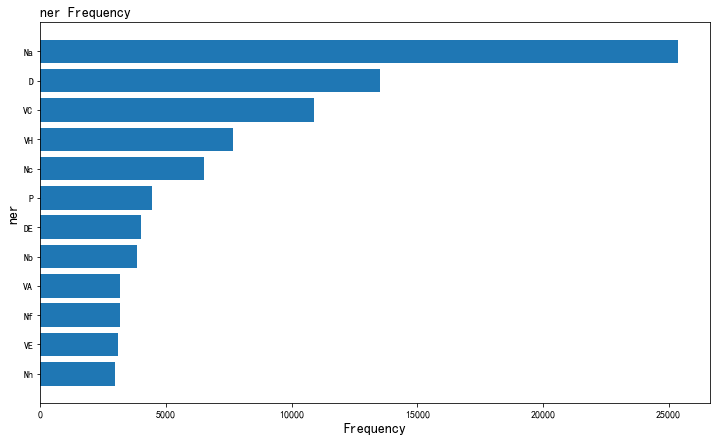

In [29]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

#### POS 常見詞性列表
+ 中研院列表: https://ckip.iis.sinica.edu.tw/service/corenlp/
    + Na: 普通名詞
    + D: 副詞
    + VC: 動作及物動詞
    + Nb: 專有名詞
    + FW: 外文
    + VH: 狀態不及物動詞
    + Nh: 代名詞
    + DE: 的之得地
    + P: 介詞
    + VA: 動作不及物動詞
    + T: 語助詞
    + SHI: 是

### 涉及到的名詞(Noun)
+ 我們可以找出談論WBC時大部分討論到的專有名詞，探索大家的關注焦點。
+ 名詞可以分為「Na: 普通名詞」、「Nb: 專有名詞」等

In [30]:
# 篩選pos為名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

,word,count
585,林襄,224
387,張育成,221
711,王建民,101
298,小玉,61
904,蔡英文,50
523,李維拉,39
27,世界棒球經典賽,32
417,悍創,31
717,王柏融,31
679,湯德章,30


C:\Users\TSH13\AppData\Local\Temp/ipykernel_4544/2128219686.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


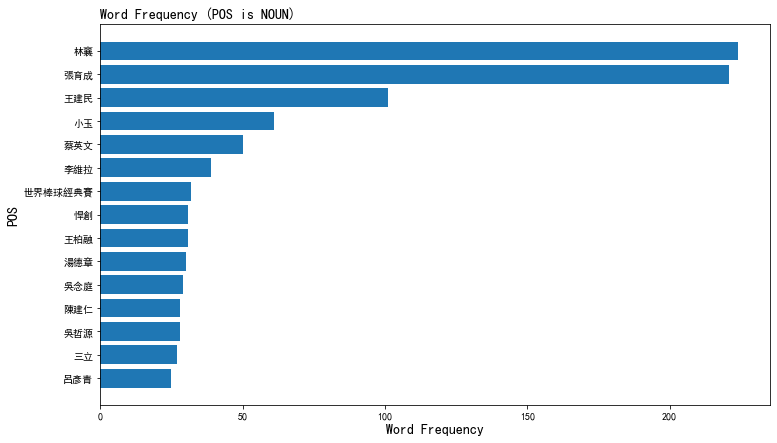

In [31]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到啦啦隊的林襄是出現最多次的專有名詞，另外，從「張育成」、「王建民」和「小玉」等專有名詞可以推測出大家對於比賽內容還是有一定的討論度，沒有完全離題都在看啦啦隊。

### 涉及到的動詞(VERB)
+ 我們可以找出談論WBC時大部分討論到的動詞，探索相關行為。
+ VC: 動作及物動詞、VH: 狀態不及物動詞、VA: 動作不及物動詞

In [32]:
l_verb = ["VA"]
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

,word,count
100,先發,79
152,前進,74
6,上場,58
341,打線,52
840,逆轉,51
362,投球,45
224,回來,42
114,出來,42
507,比賽,36
271,守備,36


C:\Users\TSH13\AppData\Local\Temp/ipykernel_4544/2587760616.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


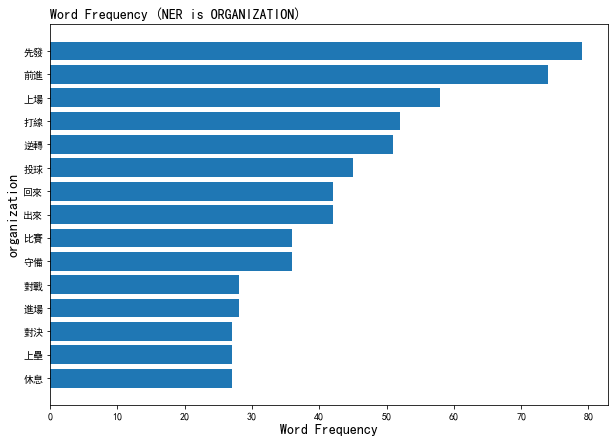

In [33]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORGANIZATION)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到動詞分析的部分，先發、打線、投球、守備、上壘等等比賽的專有名詞出現的頻率很高，而前進、回來等等看似無關的動詞，其實意同上壘跟得分，出現頻率前15高的動詞都跟比賽內容有關。

## 4. 利用SnowNLP進行情緒分析

+ SnowNLP 針對中文設計，可以提取句子的情緒分類
+ 使用文件分類法，套件已預先用文集訓練模型以判斷情緒
+ 情緒值在 0~1之間，代表負面到正面
+ 官方github: https://github.com/isnowfy/snownlp

使用先前NER得到的「世界棒球經典賽」相關文章，看看泰國相關文章的情緒表現。<br>
首先將句子和日期合併，方便之後做分析

In [34]:
sentence_table = pd.read_csv("raw_data/zh/sentence_table_buffet.csv") #匯資料

sentiment_date = pd.merge(sentence_table,thailand_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head()

,system_id,sentence,artDate,dataSource
6,2,不是啊,2023-03-08 01:00:21,ptt
7,2,你要不要先看下售票狀況啊,2023-03-08 01:00:21,ptt
8,2,最貴的張內野最便宜的連外野都賣,2023-03-08 01:00:21,ptt
9,2,結果四場中華隊的賽事都幾乎售完了,2023-03-08 01:00:21,ptt
10,2,可以容納兩萬人的洲際,2023-03-08 01:00:21,ptt


In [35]:
from  snownlp import SnowNLP
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head()

,system_id,sentence,artDate,dataSource,sentimentValue
6,2,不是啊,2023-03-08 01:00:21,ptt,0.369391
7,2,你要不要先看下售票狀況啊,2023-03-08 01:00:21,ptt,0.013922
8,2,最貴的張內野最便宜的連外野都賣,2023-03-08 01:00:21,ptt,0.994471
9,2,結果四場中華隊的賽事都幾乎售完了,2023-03-08 01:00:21,ptt,0.214307
10,2,可以容納兩萬人的洲際,2023-03-08 01:00:21,ptt,0.371652


In [36]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    9039.000000
mean        0.436974
std         0.281953
min         0.000003
25%         0.212664
50%         0.409157
75%         0.603954
max         1.000000
Name: sentimentValue, dtype: float64

<AxesSubplot:>

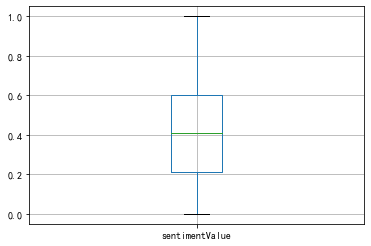

In [37]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

將每個月的情緒分數取平均，並轉換時間格式為年月日

In [38]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('D')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count.head()

,artDate,sentimentValue
0,2023-03-08,0.440837
1,2023-03-09,0.429543
2,2023-03-10,0.427942
3,2023-03-11,0.447269
4,2023-03-12,0.439415


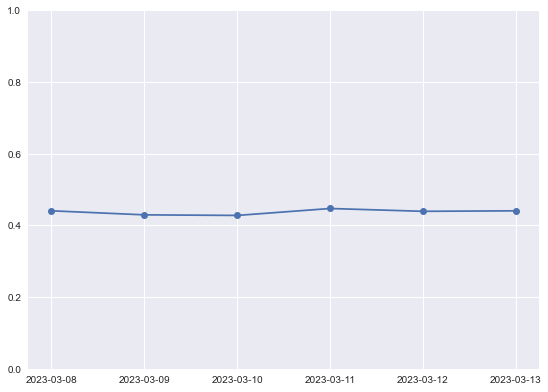

In [39]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn')

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

從上圖中發現大部分天數的情緒值都在0.4~0.5之間，偏向中性，推測是因為PTT八卦板並非專業的棒球版，對於WBC的討論不會聚焦在比賽內容，可能會多面向的去討論棒球，像是政治、比賽主辦、行銷、啦啦隊等。

### 詞彙探索
從上圖中可以發現 2023年3月11日 的情緒分數相對高，我們把這天的正面句子挑出來看看他們都用甚麼詞。

In [40]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate']=='2023-03-11']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] > 0.7]

filter_sentiment.head()

,system_id,sentence,artDate,dataSource,sentimentValue
8233,741,鄭成功除了是抗荷英雄外,2023-03-11,ptt,0.992680
8239,741,打荷蘭真的要講出鄭成功嗎,2023-03-11,ptt,0.790848
8240,742,先恭喜中華隊今晚贏球啦,2023-03-11,ptt,0.824075
8241,742,秉持體育精神也感謝義大利隊的好對手們,2023-03-11,ptt,0.889500
8242,742,如果要款待這些外國球員該開什麼菜單,2023-03-11,ptt,0.758014


In [41]:
# 把時間分數和之前斷詞的token table做 join
neg_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
neg_words = neg_words[['system_id','sentimentValue','word']]
neg_words.head()

,system_id,sentimentValue,word
0,741,0.99268,鄭成功
1,741,0.99268,除了
2,741,0.99268,是
3,741,0.99268,抗
4,741,0.99268,荷


In [42]:
# 篩選掉只有單個字元的結果
neg_words = neg_words[neg_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 正面詞彙文字雲

In [45]:
stopwords = [
    line.strip()
    for line in open("dict/stopwords.txt", "r", encoding="utf-8").readlines()
]
#匯入自訂停用詞檔案
for stop in open("dict/user_stopwords.txt", "r", encoding="utf-8").readlines():
    stopwords.append(stop.strip())

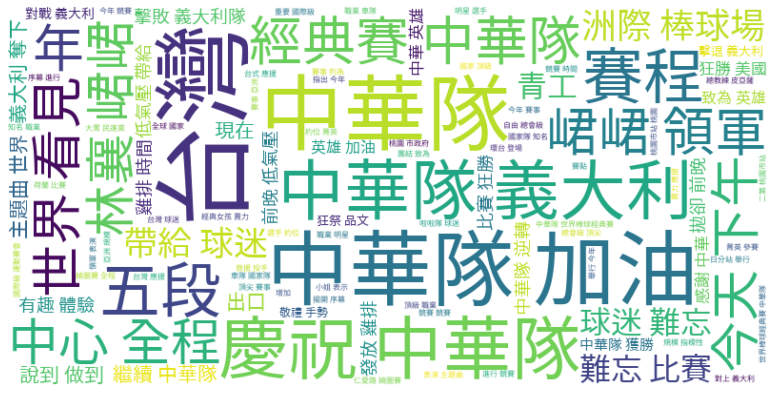

In [46]:
# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stopwords,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(neg_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()